<a href="https://colab.research.google.com/github/yingjun-mou/CLIP/blob/master/Reproduce_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notework aims to reproduce CLIP model proposed in *Learning Transferable Visual Models From Natural Language Supervision*.

# Part 1. Use exisiting open_clip model

Task: Use open_clip to perform image classifications

##Step 1. Colab preparation

In [16]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [17]:
! pip install open_clip_torch matplotlib

In [18]:
import numpy as np
import torch

## Step 2. Loading the model

In [19]:
import open_clip

# List the names of all available CLIP models.
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_image_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_text_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_basic_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_s13m_b4k'),
 ('ViT-

In [20]:
# Load one of the models.
model, _, preprocess = open_clip.create_model_and_transforms('convnext_base_w', pretrained='laion2b_s13b_b82k_augreg')

In [21]:
model.eval()
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)


Model parameters: 179,385,345
Context length: 77
Vocab size: 49408


## Step 3. Image Preprocessing

* normalize the pixel intensity using the dataset mean and standard deviation
* resize the input images
* center-crop them to conform with the image resolution that model expects

In [22]:
preprocess

Compose(
    Resize(size=256, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(256, 256))
    <function _convert_to_rgb at 0x79b3e3a92fc0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

##Step 4. Text Preprocessing

* Use a case-insensitive tokenizer `tokenizer.tokenize()`. It will pad the outputs to become 77 tokens long, which is the CLIP model expects.

In [23]:
from open_clip import tokenizer

In [24]:
tokenizer.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])

##Step 5. Set up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [25]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}


In [27]:
skimage.data.download_all(directory=None)

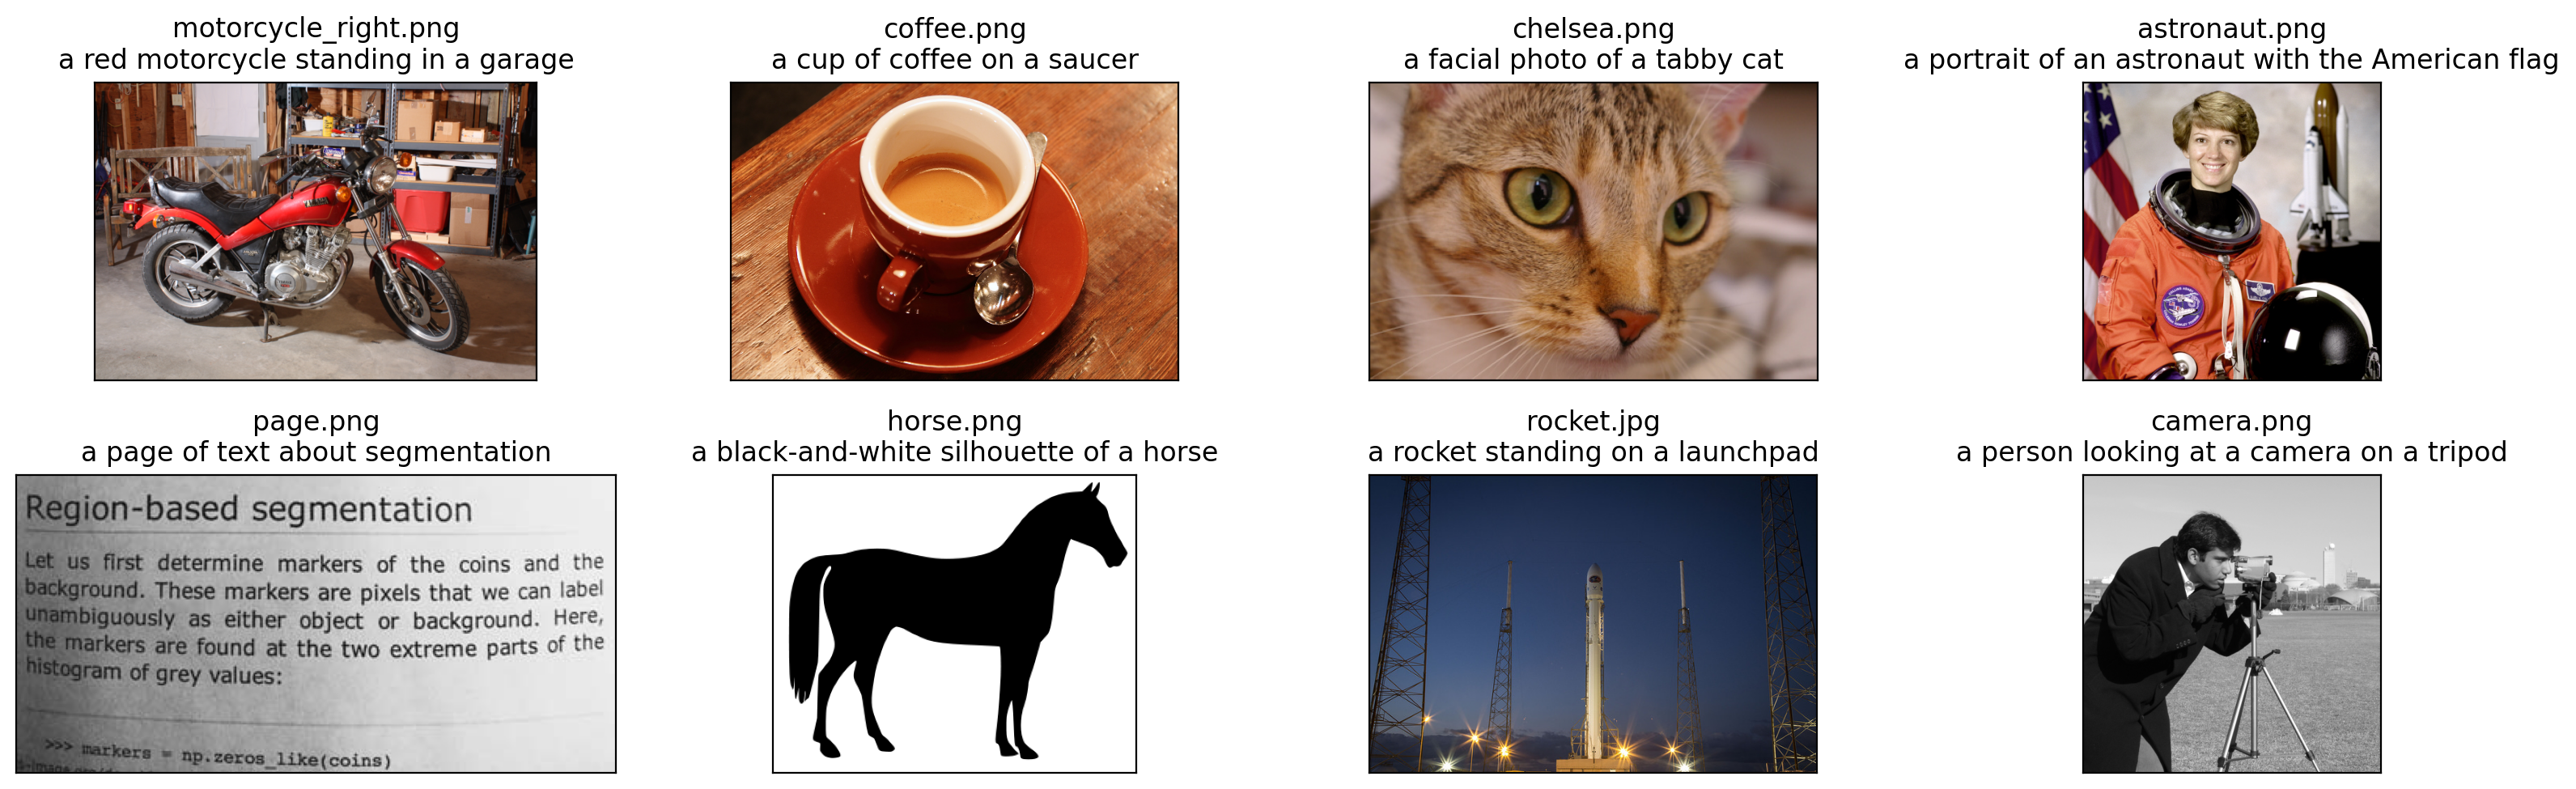

In [32]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16,5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
  name = os.path.splitext(filename)[0]
  if name not in descriptions:
    continue

  image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

  plt.subplot(2, 4, len(images) +1)
  plt.imshow(image)
  plt.title(f"{filename}\n{descriptions[name]}")
  plt.xticks([])
  plt.yticks([])

  original_images.append(image)
  images.append(preprocess(image))
  texts.append(descriptions[name])

plt.tight_layout()


##Step 6. Building features

Normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [33]:
image_input = torch.tensor(np.stack(images))
text_tokens = tokenizer.tokenize(["This is " + desc for desc in texts])

In [34]:
with torch.no_grad():
  image_features = model.encode_image(image_input).float()
  text_features = model.encode_text(text_tokens).float()

##Step 7. Calculate feature similarity

Cosine similarity was chosen.

In [35]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

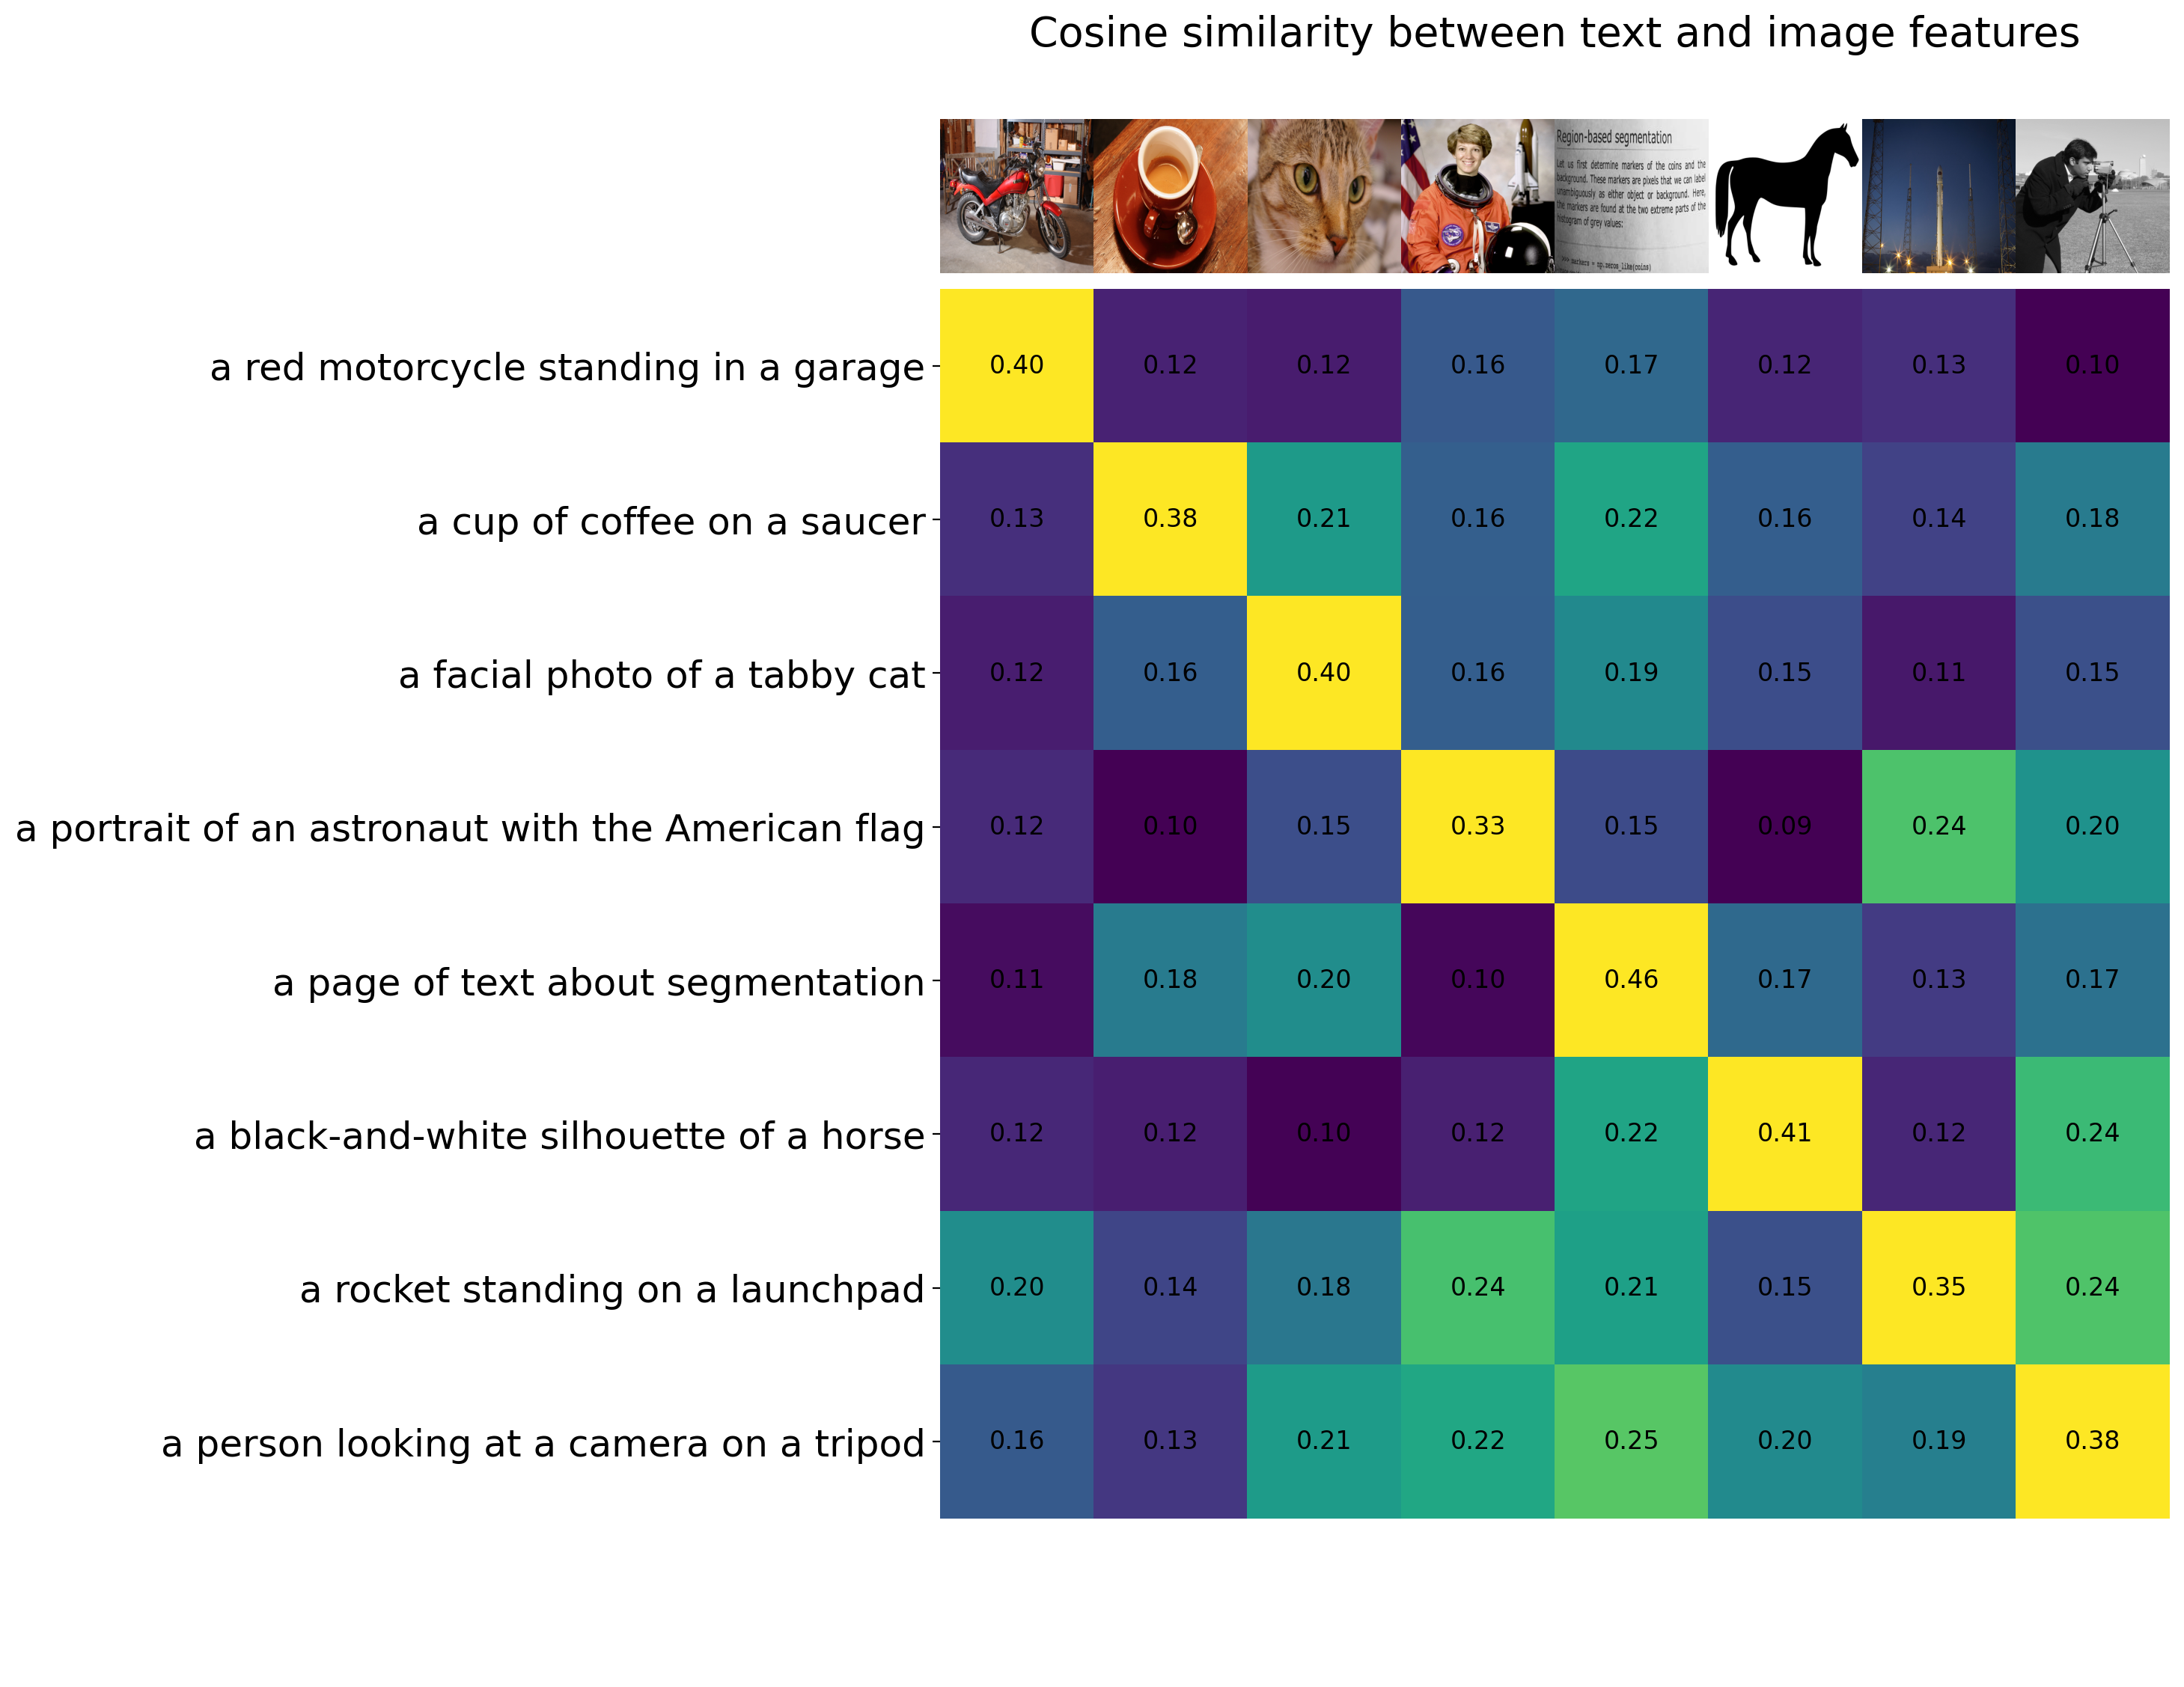

In [37]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)

plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])

for i, image in enumerate(original_images):
  plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

for x in range(similarity.shape[1]):
  for y in range(similarity.shape[0]):
    plt.text(x, y, f"{similarity[y,x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

##Step 8. Zero-Shot Image Classification

Classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [38]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 169M/169M [00:03<00:00, 46.3MB/s]


In [40]:
text_descriptions = [f"A photo of a {label}" for label in cifar100.classes]
text_tokens = tokenizer.tokenize(text_descriptions)

In [41]:
with torch.no_grad():
  text_features = model.encode_text(text_tokens).float()
  text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

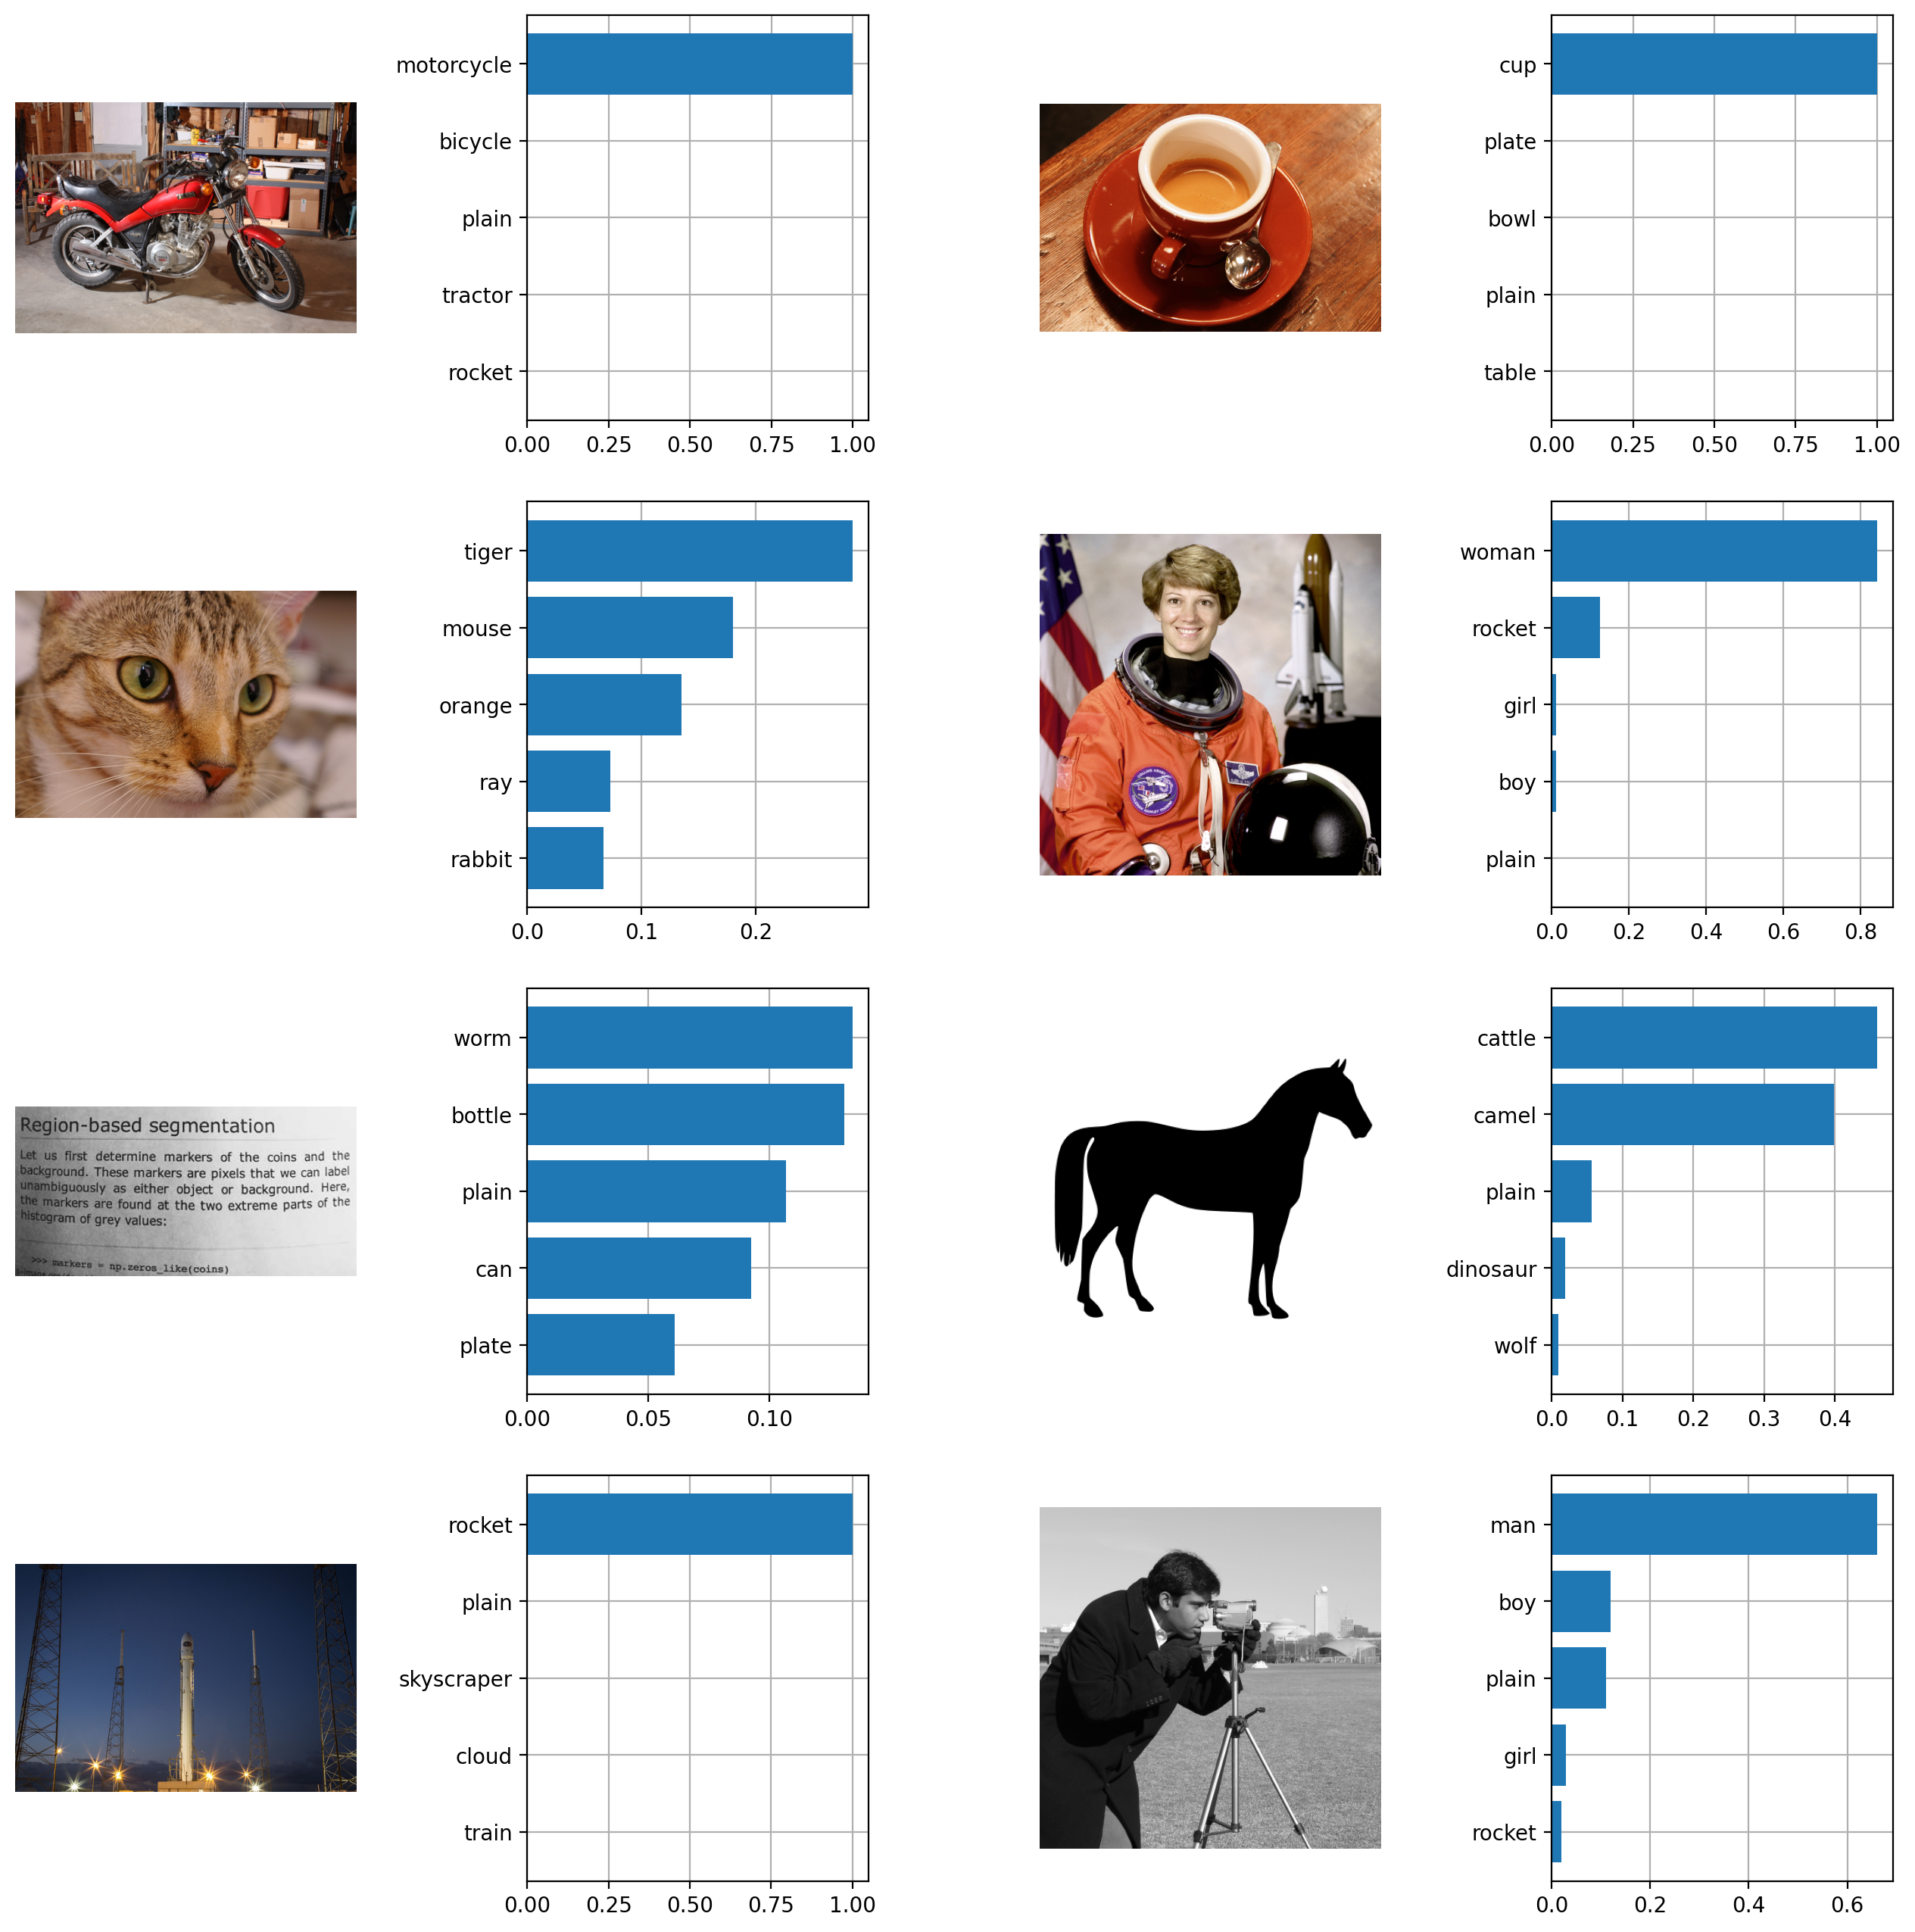

In [42]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
  plt.subplot(4, 4, 2 * i + 1)
  plt.imshow(image)
  plt.axis("off")

  plt.subplot(4, 4, 2 * i +2)
  y = np.arange(top_probs.shape[-1])
  plt.grid()
  plt.barh(y, top_probs[i])
  plt.gca().invert_yaxis()
  plt.gca().set_axisbelow(True)
  plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])

plt.subplots_adjust(wspace=0.5)
plt.show()